In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

from numpy import array
import scipy.sparse

%matplotlib inline

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Load the data

In [2]:
def adapter(indptr, indices, data):
    for i in range(len(indptr), indptr[-1] + 1):
        indptr = np.append(indptr, indptr[-1])
    return (indptr, indices, data)

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')

np.set_printoptions(threshold=np.inf)

# washington_test 2
# indptr = array([0,1,3,4,5,6,7,8,9,9])
# indices = array([1,2,3,4,5,6,6,7,8])
# data = array([1,1,1,1,1,1,1,1,1])

# washington_test 20
# indptr = array([0,1,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,81])
# indices = array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62])
# data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

# chain_generator (3, 3)
# indptr = array([0,3,5,7,11,13,15,18,20,22])
# indices = array([1,2,3,0,2,1,0,4,5,0,6,3,5,4,3,7,8,3,6,8,7,6])
# data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

# chain_generator (5, 3)
indptr = array([0,3,5,7,11,13,15,19,21,23,27,29,31,34,36,38])
indices = array([1,2,3,0,2,1,0,4,5,0,6,3,5,4,3,7,8,3,9,6,8,7,6,10,11,6,12,9,11,10,9,13,14,9,12,14,13,12])
data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

# chain_generator (11, 3)
indptr = array([0,3,5,7,11,13,15,19,21,23,27,29,31,35,37,39,43,45,47,51,53,55,59,61,63,67,69,71,75,77,79,82,84,86])
indices = array([1,2,3,0,2,1,0,4,5,0,6,3,5,4,3,7,8,3,9,6,8,7,6,10,11,6,12,9,11,10,9,13,14,9,15,12,14,13,12,16,17,12,18,15,17,16,15,19,20,15,21,18,20,19,18,22,23,18,24,21,23,22,21,25,26,21,27,24,26,25,24,28,29,24,30,27,29,28,27,31,32,27,30,32,31,30])
data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

# cube 4
indptr = array([0,3,7,11,14,18,23,28,32,36,41,46,50,53,57,61,64,68,73,78,82,87,93,99,104,109,115,121,126,130,135,140,144,148,153,158,162,167,173,179,184,189,195,201,206,210,215,220,224,227,231,235,238,242,247,252,256,260,265,270,274,277,281,285,288,])
indices = array([16,4,1,17,5,0,2,18,6,1,3,19,7,2,20,0,8,5,21,1,9,4,6,22,2,10,5,7,23,3,11,6,24,4,12,9,25,5,13,8,10,26,6,14,9,11,27,7,15,10,28,8,13,29,9,12,14,30,10,13,15,31,11,14,0,32,20,17,1,33,21,16,18,2,34,22,17,19,3,35,23,18,4,36,16,24,21,5,37,17,25,20,22,6,38,18,26,21,23,7,39,19,27,22,8,40,20,28,25,9,41,21,29,24,26,10,42,22,30,25,27,11,43,23,31,26,12,44,24,29,13,45,25,28,30,14,46,26,29,31,15,47,27,30,16,48,36,33,17,49,37,32,34,18,50,38,33,35,19,51,39,34,20,52,32,40,37,21,53,33,41,36,38,22,54,34,42,37,39,23,55,35,43,38,24,56,36,44,41,25,57,37,45,40,42,26,58,38,46,41,43,27,59,39,47,42,28,60,40,45,29,61,41,44,46,30,62,42,45,47,31,63,43,46,32,52,49,33,53,48,50,34,54,49,51,35,55,50,36,48,56,53,37,49,57,52,54,38,50,58,53,55,39,51,59,54,40,52,60,57,41,53,61,56,58,42,54,62,57,59,43,55,63,58,44,56,61,45,57,60,62,46,58,61,63,47,59,62,])
data = array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,])



indptr, indices, data = adapter(indptr, indices, data)

_A_obs = scipy.sparse.csr_matrix((data, indices, indptr), shape=(indptr[-1], indptr[-1]))
print(_A_obs.toarray())

_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

[[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [4]:
val_share = 0.1
test_share = 0.05
# seed = 481516234
seed = 12412543

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 8

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [9]:
walker.walk().__next__()

array([[16,  0,  1,  0, 16,  0,  1,  0, 16, 20, 36, 52, 36, 20, 16, 20],
       [54, 38, 34, 50, 34, 38, 37, 36, 20, 16, 20, 36, 37, 41, 37, 36],
       [40, 41, 57, 56, 60, 61, 60, 56, 57, 56, 40, 56, 57, 56, 40, 44],
       [22, 18, 34, 35, 34, 38, 22, 23, 27, 11, 15, 14, 10,  9, 13, 12],
       [ 9,  5, 21, 25, 21, 25, 26, 22, 23,  7, 11,  7, 11,  7, 11, 27],
       [21,  5,  9,  8,  9, 13, 14, 13,  9,  8,  9, 10,  6,  2,  6,  2],
       [45, 46, 62, 61, 62, 63, 59, 55, 39, 55, 51, 50, 49, 48, 52, 36],
       [32, 48, 49, 48, 52, 53, 49, 33, 49, 33, 37, 38, 54, 58, 62, 63]])

#### Create our NetGAN model

In [10]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5, batch_size=batch_size,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

#### Define the stopping criterion

In [11]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [12]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_15.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****
**** Training completed after 599 iterations. ****


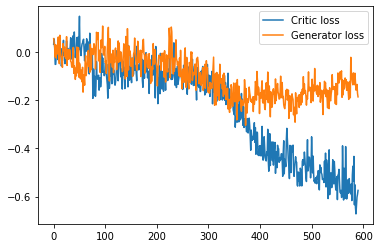

In [13]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=600)

In [14]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

In [15]:
# print(log_dict['val_performances'])
# plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
#          np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
# plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
#          np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

# plt.title("Validation performance during training")
# plt.legend()
# plt.show()

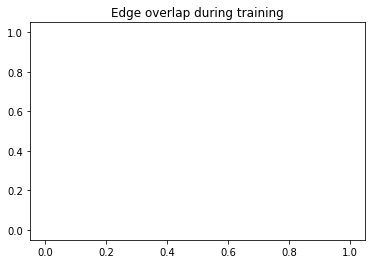

In [16]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [17]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [18]:
samples = []

In [19]:
for _ in range(100):
    if (_+1) % 5 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99


#### Assemble score matrix from the random walks

In [20]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [21]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [22]:
roc_auc_score(test_labels, test_scores)

0.375

In [23]:
average_precision_score(test_labels, test_scores)

0.6116862304362305

In [24]:
print(scores_matrix)

  (0, 0)	4044.0
  (0, 1)	2989.0
  (0, 2)	5549.0
  (0, 3)	3430.0
  (0, 4)	4991.0
  (0, 5)	4817.0
  (0, 6)	6386.0
  (0, 7)	4841.0
  (0, 8)	4916.0
  (0, 9)	5261.0
  (0, 10)	4051.0
  (0, 11)	5256.0
  (0, 12)	2960.0
  (0, 13)	4808.0
  (0, 14)	6387.0
  (0, 15)	4157.0
  (0, 16)	2713.0
  (0, 17)	4635.0
  (0, 18)	6679.0
  (0, 19)	5022.0
  (0, 20)	4329.0
  (0, 21)	5910.0
  (0, 22)	6255.0
  (0, 23)	8354.0
  (0, 24)	2955.0
  :	:
  (63, 39)	9745.0
  (63, 40)	5774.0
  (63, 41)	9534.0
  (63, 42)	11877.0
  (63, 43)	9215.0
  (63, 44)	6916.0
  (63, 45)	6900.0
  (63, 46)	9740.0
  (63, 47)	9798.0
  (63, 48)	5991.0
  (63, 49)	6947.0
  (63, 50)	6678.0
  (63, 51)	7347.0
  (63, 52)	4951.0
  (63, 53)	7420.0
  (63, 54)	9365.0
  (63, 55)	9327.0
  (63, 56)	4254.0
  (63, 57)	7979.0
  (63, 58)	9110.0
  (63, 59)	10060.0
  (63, 60)	8116.0
  (63, 61)	7959.0
  (63, 62)	7650.0
  (63, 63)	8264.0


In [25]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))
print(A_select)

  (0, 1)	1.0
  (0, 4)	1.0
  (0, 16)	1.0
  (1, 0)	1.0
  (1, 17)	1.0
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 18)	1.0
  (3, 2)	1.0
  (3, 19)	1.0
  (4, 0)	1.0
  (4, 5)	1.0
  (4, 8)	1.0
  (4, 20)	1.0
  (5, 4)	1.0
  (5, 6)	1.0
  (5, 9)	1.0
  (5, 21)	1.0
  (6, 2)	1.0
  (6, 5)	1.0
  (6, 7)	1.0
  (6, 10)	1.0
  (7, 6)	1.0
  (7, 11)	1.0
  (7, 23)	1.0
  :	:
  (57, 58)	1.0
  (57, 61)	1.0
  (58, 42)	1.0
  (58, 54)	1.0
  (58, 57)	1.0
  (58, 59)	1.0
  (58, 62)	1.0
  (59, 43)	1.0
  (59, 55)	1.0
  (59, 58)	1.0
  (59, 63)	1.0
  (60, 44)	1.0
  (60, 56)	1.0
  (60, 61)	1.0
  (61, 45)	1.0
  (61, 57)	1.0
  (61, 60)	1.0
  (61, 62)	1.0
  (62, 46)	1.0
  (62, 58)	1.0
  (62, 61)	1.0
  (62, 63)	1.0
  (63, 47)	1.0
  (63, 59)	1.0
  (63, 62)	1.0


In [26]:
print(_A_obs)

  (0, 1)	1
  (0, 4)	1
  (0, 16)	1
  (1, 0)	1
  (1, 2)	1
  (1, 5)	1
  (1, 17)	1
  (2, 1)	1
  (2, 3)	1
  (2, 6)	1
  (2, 18)	1
  (3, 2)	1
  (3, 7)	1
  (3, 19)	1
  (4, 0)	1
  (4, 5)	1
  (4, 8)	1
  (4, 20)	1
  (5, 1)	1
  (5, 4)	1
  (5, 6)	1
  (5, 9)	1
  (5, 21)	1
  (6, 2)	1
  (6, 5)	1
  :	:
  (57, 58)	1
  (57, 61)	1
  (58, 42)	1
  (58, 54)	1
  (58, 57)	1
  (58, 59)	1
  (58, 62)	1
  (59, 43)	1
  (59, 55)	1
  (59, 58)	1
  (59, 63)	1
  (60, 44)	1
  (60, 56)	1
  (60, 61)	1
  (61, 45)	1
  (61, 57)	1
  (61, 60)	1
  (61, 62)	1
  (62, 46)	1
  (62, 58)	1
  (62, 61)	1
  (62, 63)	1
  (63, 47)	1
  (63, 59)	1
  (63, 62)	1


In [27]:
print(A_select != _A_obs)

  (1, 2)	True
  (1, 5)	True
  (2, 1)	True
  (3, 7)	True
  (5, 1)	True
  (6, 22)	True
  (7, 3)	True
  (10, 11)	True
  (10, 26)	True
  (11, 10)	True
  (16, 17)	True
  (16, 32)	True
  (17, 16)	True
  (19, 23)	True
  (20, 24)	True
  (21, 22)	True
  (22, 6)	True
  (22, 21)	True
  (23, 19)	True
  (24, 20)	True
  (24, 25)	True
  (25, 24)	True
  (26, 10)	True
  (26, 30)	True
  (29, 30)	True
  (30, 26)	True
  (30, 29)	True
  (32, 16)	True
  (32, 33)	True
  (32, 36)	True
  (33, 32)	True
  (33, 34)	True
  (34, 33)	True
  (36, 32)	True
  (36, 40)	True
  (38, 39)	True
  (39, 38)	True
  (40, 36)	True
  (50, 54)	True
  (52, 56)	True
  (53, 54)	True
  (54, 50)	True
  (54, 53)	True
  (56, 52)	True


In [28]:
i = 0
for row in _A_obs.todense():
    row = np.array(row).flatten()
    for j in range(i, len(row)):
        if row[j] > 0:
            print(i+1, j+1, 1)
    i += 1

1 2 1
1 5 1
1 17 1
2 3 1
2 6 1
2 18 1
3 4 1
3 7 1
3 19 1
4 8 1
4 20 1
5 6 1
5 9 1
5 21 1
6 7 1
6 10 1
6 22 1
7 8 1
7 11 1
7 23 1
8 12 1
8 24 1
9 10 1
9 13 1
9 25 1
10 11 1
10 14 1
10 26 1
11 12 1
11 15 1
11 27 1
12 16 1
12 28 1
13 14 1
13 29 1
14 15 1
14 30 1
15 16 1
15 31 1
16 32 1
17 18 1
17 21 1
17 33 1
18 19 1
18 22 1
18 34 1
19 20 1
19 23 1
19 35 1
20 24 1
20 36 1
21 22 1
21 25 1
21 37 1
22 23 1
22 26 1
22 38 1
23 24 1
23 27 1
23 39 1
24 28 1
24 40 1
25 26 1
25 29 1
25 41 1
26 27 1
26 30 1
26 42 1
27 28 1
27 31 1
27 43 1
28 32 1
28 44 1
29 30 1
29 45 1
30 31 1
30 46 1
31 32 1
31 47 1
32 48 1
33 34 1
33 37 1
33 49 1
34 35 1
34 38 1
34 50 1
35 36 1
35 39 1
35 51 1
36 40 1
36 52 1
37 38 1
37 41 1
37 53 1
38 39 1
38 42 1
38 54 1
39 40 1
39 43 1
39 55 1
40 44 1
40 56 1
41 42 1
41 45 1
41 57 1
42 43 1
42 46 1
42 58 1
43 44 1
43 47 1
43 59 1
44 48 1
44 60 1
45 46 1
45 61 1
46 47 1
46 62 1
47 48 1
47 63 1
48 64 1
49 50 1
49 53 1
50 51 1
50 54 1
51 52 1
51 55 1
52 56 1
53 54 1
53 57 1
54 5

In [29]:
i = 0
for row in A_select.todense():
    row = np.array(row).flatten()
    for j in range(i, len(row)):
        if row[j] > 0:
            print(i+1, j+1, 1)
    i += 1

1 2 1
1 5 1
1 17 1
2 18 1
3 4 1
3 7 1
3 19 1
4 20 1
5 6 1
5 9 1
5 21 1
6 7 1
6 10 1
6 22 1
7 8 1
7 11 1
8 12 1
8 24 1
9 10 1
9 13 1
9 25 1
10 11 1
10 14 1
10 26 1
11 15 1
12 16 1
12 28 1
13 14 1
13 29 1
14 15 1
14 30 1
15 16 1
15 31 1
16 32 1
17 21 1
18 19 1
18 22 1
18 34 1
19 20 1
19 23 1
19 35 1
20 36 1
21 22 1
21 37 1
22 26 1
22 38 1
23 24 1
23 27 1
23 39 1
24 28 1
24 40 1
25 29 1
25 41 1
26 27 1
26 30 1
26 42 1
27 28 1
27 43 1
28 32 1
28 44 1
29 30 1
29 45 1
30 46 1
31 32 1
31 47 1
32 48 1
33 49 1
34 38 1
34 50 1
35 36 1
35 39 1
35 51 1
36 40 1
36 52 1
37 38 1
37 53 1
38 39 1
38 42 1
38 54 1
39 43 1
39 55 1
40 44 1
40 56 1
41 42 1
41 45 1
41 57 1
42 43 1
42 46 1
42 58 1
43 44 1
43 47 1
43 59 1
44 48 1
44 60 1
45 46 1
45 61 1
46 47 1
46 62 1
47 48 1
47 63 1
48 64 1
49 50 1
49 53 1
50 51 1
50 54 1
51 52 1
52 56 1
53 54 1
54 58 1
55 56 1
55 59 1
56 60 1
57 58 1
57 61 1
58 59 1
58 62 1
59 60 1
59 63 1
60 64 1
61 62 1
62 63 1
63 64 1
